In [1]:
# loading the packages needed for this project
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
import os

# Define the path to the zip file and the extraction directory
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
zip_file_path = os.path.join(desktop_path, 'Jules', 'house-prices-advanced-regression-techniques.zip')
extraction_path = os.path.join(desktop_path, 'Jules')

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Load the dataset into a Pandas DataFrame
csv_file_path = os.path.join(extraction_path, 'train.csv')
train_data = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame to ensure it loaded correctly
#print(train_data.head())
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
# Inspect the dataset for missing values
missing_values = train_data.isnull().sum().sort_values(ascending=False)
missing_values

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

In [4]:
# Separate numeric columns and non-numeric columns
numeric_cols = train_data.select_dtypes(include=['number'])
non_numeric_cols = train_data.select_dtypes(exclude=['number'])

# Fill missing values in numeric columns with the median
numeric_cols_filled = numeric_cols.fillna(numeric_cols.median())

# Combine numeric and non-numeric columns back into a single DataFrame
train_data_filled = pd.concat([numeric_cols_filled, non_numeric_cols], axis=1)

# Display the first few rows of the DataFrame to ensure it loaded correctly
print(train_data_filled.head())

   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  GarageType  GarageFinish  \
0          2003       196.0         706  ...      Attchd           RFn   
1          1976         0.0         978  ...      Attchd           RFn   
2          2002       162.0         486  ...      Attchd           RFn   
3          1970         0.0         216  ...      Detchd           Unf   
4          2000       350.0         655  ...      Attchd           RFn   

   GarageQual  GarageCond  PavedDrive  PoolQC  Fence  MiscFeature  SaleTyp

In [5]:
# Perform data cleaning to ensure the dataset is ready for analysis
initial_rows = train_data.shape[0]
train_data_cleaned = train_data_filled.copy()

# Display the first few rows of the cleaned data
print(train_data_cleaned.head(), initial_rows, missing_values.head(10))

   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  GarageType  GarageFinish  \
0          2003       196.0         706  ...      Attchd           RFn   
1          1976         0.0         978  ...      Attchd           RFn   
2          2002       162.0         486  ...      Attchd           RFn   
3          1970         0.0         216  ...      Detchd           Unf   
4          2000       350.0         655  ...      Attchd           RFn   

   GarageQual  GarageCond  PavedDrive  PoolQC  Fence  MiscFeature  SaleTyp

C:\Users\Barry J\anaconda3\envs\DS_Explore\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


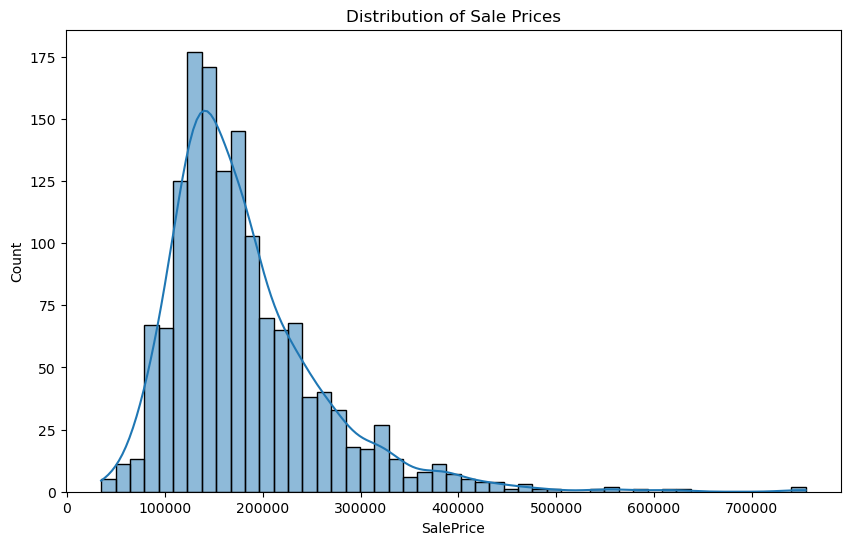

In [6]:
# Phase 2: Exploratory Data Analysis (EDA)

# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(train_data_cleaned['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.show()


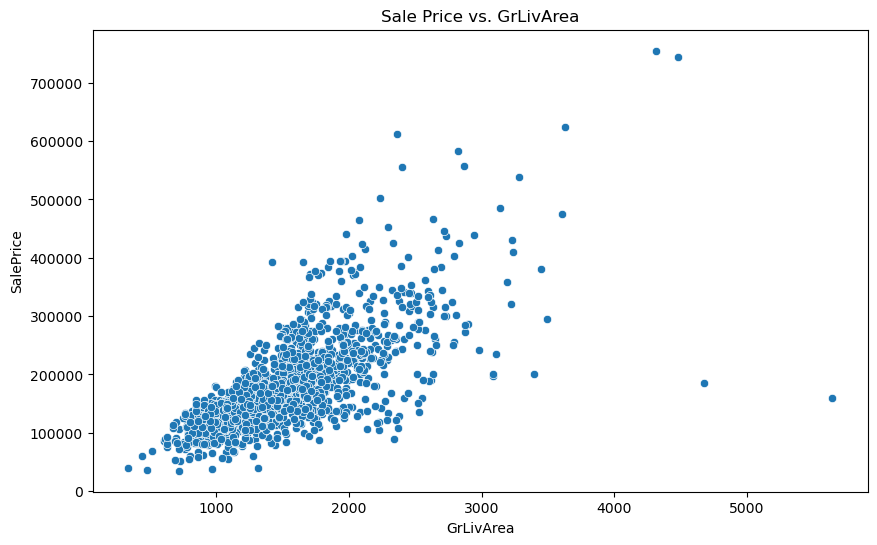

In [7]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data_cleaned)
plt.title('Sale Price vs. GrLivArea')
plt.show()

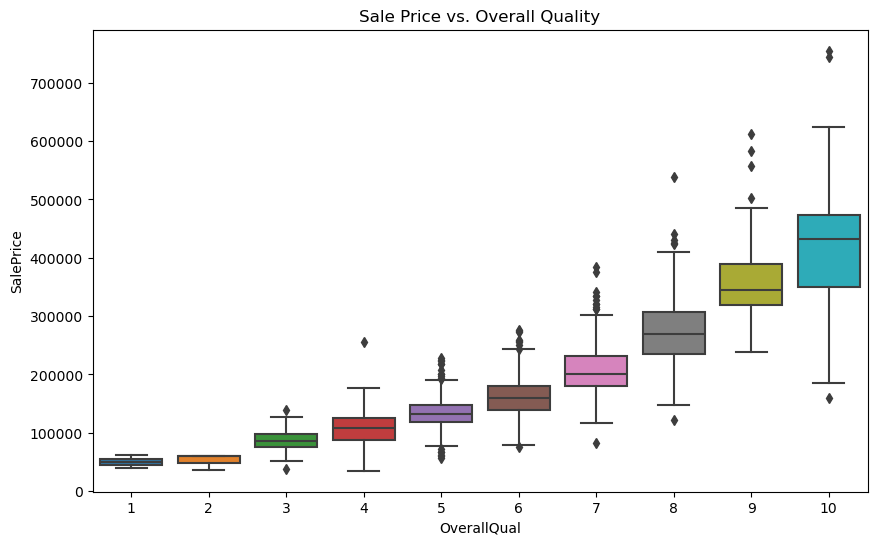

In [8]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_data_cleaned)
plt.title('Sale Price vs. Overall Quality')
plt.show()

In [9]:
# Identifying outliers using z-score
z_scores = stats.zscore(train_data_cleaned.select_dtypes(include=[np.number]))
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3).sum(axis=1)
outlier_rows = train_data_cleaned[outliers > 0].index
train_data_cleaned = train_data_cleaned.drop(outlier_rows)

print(train_data_cleaned.describe(), train_data_cleaned.head())


                Id   MSSubClass  LotFrontage       LotArea  OverallQual  \
count  1015.000000  1015.000000  1015.000000   1015.000000  1015.000000   
mean    735.600985    53.931034    67.303448   9139.664039     6.072906   
std     423.369253    40.369535    18.267801   3634.390581     1.314689   
min       1.000000    20.000000    21.000000   1300.000000     2.000000   
25%     377.500000    20.000000    60.000000   7200.000000     5.000000   
50%     735.000000    50.000000    69.000000   9066.000000     6.000000   
75%    1105.500000    60.000000    76.000000  10996.000000     7.000000   
max    1457.000000   180.000000   134.000000  29959.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1015.000000  1015.000000   1015.000000  1015.000000  1015.000000  ...   
mean      5.521182  1975.111330   1986.039409    82.213793   413.388177  ...   
std       0.984743    29.052194     20.737640   130.064354   403.773301  ...   
min 

In [10]:
# Phase 3: Feature Engineering

# 3.1: Create new features
train_data_cleaned['TotalSF'] = train_data_cleaned['TotalBsmtSF'] + train_data_cleaned['1stFlrSF'] + train_data_cleaned['2ndFlrSF']

# 3.2: Encode categorical variables
train_data_encoded = pd.get_dummies(train_data_cleaned)

# 3.3: Normalize or standardize numerical features
scaler = StandardScaler()
numerical_cols = train_data_encoded.select_dtypes(include=[np.number]).columns
train_data_encoded[numerical_cols] = scaler.fit_transform(train_data_encoded[numerical_cols])

# Display the first few rows of the processed data
print(train_data_encoded.head())


          Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
0  -1.735986    0.150409    -0.126156 -0.189854     0.705529    -0.529518   
2  -1.731260    0.150409     0.038149  0.580944     0.705529    -0.529518   
4  -1.726533    0.150409     0.914439  1.409551     1.466540    -0.529518   
6  -1.721807   -0.840925     0.421526  0.259961     1.466540    -0.529518   
10 -1.712354   -0.840925     0.147685  0.567179    -0.816494    -0.529518   

    YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLw  \
0    0.960424      0.818268    0.875277    0.725051  ...           False   
2    0.891548      0.770023    0.613739    0.179922  ...           False   
4    0.857110      0.673532    2.059890    0.598680  ...           False   
6    0.994862      0.914759    0.798354    2.367871  ...           False   
10  -0.348212     -1.015052   -0.632412    1.220622  ...           False   

    SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0         

In [11]:
# Phase 4: Model Training and Evaluation

# Define target and features
X = train_data_encoded.drop('SalePrice', axis=1)
y = train_data_encoded['SalePrice']

# 4.1: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# 4.2: Choose and justify the selection of machine learning algorithms
# Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)


In [13]:
# Random Forest
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)


In [14]:
# 4.3: Train multiple models and evaluate their performance using appropriate metrics
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)


In [15]:
# 4.4: Perform hyperparameter tuning to optimize the model's performance
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_


In [16]:
# 4.5: Select and evaluate the best-performing model on the testing set
y_pred_best = best_rf_model.predict(X_test)
rmse_best = mean_squared_error(y_test, y_pred_best, squared=False)

In [17]:
# Summary results
rmse_results = {
    "Linear Regression RMSE": rmse_lr,
    "Random Forest RMSE": rmse_rf,
    "Best Model RMSE": rmse_best,
}

print(rmse_results, best_rf_model)

{'Linear Regression RMSE': 139260627752.467, 'Random Forest RMSE': 0.29934269764909005, 'Best Model RMSE': 0.29934269764909005} RandomForestRegressor(random_state=42)
